In [ ]:
'''
from mmpose.apis import (init_pose_model, inference_bottom_up_pose_model, vis_pose_result)

# Load a pre-trained model (you need to download them manualy first)
config_file = 'associative_embedding_hrnet_w32_coco_512x512.py'
checkpoint_file = 'hrnet_w32_coco_512x512-bcb8c247_20200816.pth'
pose_model = init_pose_model(config_file, checkpoint_file, device='cpu')  # or device='cuda:0'

image_name = 'STROKE/AAA/1.PNG'

# test a single image
pose_results, _ = inference_bottom_up_pose_model(pose_model, image_name)

# show the results
vis_pose_result(pose_model, image_name, pose_results, out_file='STROKE/AAA/out.jpg')
'''

In [ ]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

In [ ]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector

import cv2
import os
import numpy as np
import pandas as pd
from pathlib import Path

In [ ]:
# SETTINGS

PATH_data = 'STROKE/data/'
PATH_output = 'STROKE/data_good_output/'

pose_config = 'configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w48_coco_256x192.py'
#pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth'
pose_checkpoint = 'hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth'
MAX_POINT = 17

det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
#det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
det_checkpoint = 'faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'


# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)
# initialize detector
det_model = init_detector(det_config, det_checkpoint)

In [ ]:
def calculate_show_keypoints_coordinates (det_model, pose_model, img_path, show:bool ) -> list:
    # inference detection
    mmdet_results = inference_detector(det_model, img_path)

    # extract person (COCO_ID=1) bounding boxes from the detection results
    person_results = process_mmdet_results(mmdet_results, cat_id=1)

    # inference pose
    pose_results, returned_outputs = inference_top_down_pose_model(
        pose_model,
        img_path,
        person_results,
        bbox_thr=0.3,
        format='xyxy',
        dataset=pose_model.cfg.data.test.type)

    # show results
    if show:
        # show pose estimation results
        vis_result = vis_pose_result(
              pose_model,
              img_path,
              pose_results,
              dataset=pose_model.cfg.data.test.type,
              show=False)
        # reduce image size
        vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

        from IPython.display import Image, display
        #import tempfile
        import os.path as osp

        file_name = osp.join(PATH_output, 'tmp_output.png')
        cv2.imwrite(file_name, vis_result)
        display(Image(file_name))

    if len(pose_results) == 0:
        #print("A HUMAN WAS NOT DETECTED.")
        keypoints = []
        for i in range(MAX_POINT):
            keypoints.append( [-1,-1,-1] )
        keypoints = np.array(keypoints, dtype=np.float32)
        #print(keypoints)
        return keypoints

    if len(pose_results) == 2:
        #print("MULTIPLE PEOPLE WERE DETECTED.")
        keypoints = []
        for i in range(MAX_POINT):
            keypoints.append( [-2,-2,-2] )
        keypoints = np.array(keypoints, dtype=np.float32)
        return keypoints


    keypoints = pose_results[0]['keypoints']

    return keypoints

In [ ]:
# DATA SOURCE
#img_path = 'STROKE/AAA/1.PNG'
img_path = 'STROKE/data/patients/GD_23_test.PNG'

coordinates = list()
show_result = True

keypoints = calculate_show_keypoints_coordinates (det_model, pose_model, img_path, show_result)
coordinates.append(keypoints)

print (keypoints)

In [ ]:
# Initialize the frames directory. We will divide our videos into a sequence of frames and save there
PATH_frames = PATH_data + 'frames/'

def create_folder(path, overwrite=False):
    # Check the directory name exist or not. Overwrite it if it exists or create if it not.
    folder_path = Path(path)
    if os.path.isdir(path) == False:
        folder_path.mkdir(parents=True, exist_ok=True)
        #os.mkdir(path)
        print("The directory is created.")
    else:
        if (overwrite):
            print("The directory already exists. Folder overwritinig ...")
            import shutil
            shutil.rmtree(path)
            folder_path.mkdir(parents=True, exist_ok=True)
            #os.mkdir(path)
        else:
            print("The directory already exists. Nothing happened.")

create_folder (PATH_frames, overwrite=True)

The directory already exists. Folder overwritinig ...


In [ ]:
# Selected COCO keypoints: left and right hands
points_list = [1,2,3,4,5,6,7,8,9,10]
# 1="left_eye", 2="right_eye", 3="left_ear", 4="right_ear",
# 5 = 'left_shoulder", 6="right_shoulder", 7="left_elbow", 8="right_elbow",
# 9="left_wrist", 10="right_wrist".

# Create labels for columns in DataFrame
all_coordinates = []
for point in points_list:
    cur_point_coordinates = []
    name = 'X' + str(point)
    cur_point_coordinates.append(name)
    name = 'Y' + str(point)
    cur_point_coordinates.append(name)
    name = 'Z' + str(point)
    cur_point_coordinates.append(name)
    all_coordinates.append(cur_point_coordinates)

all_coordinates_np = np.array(all_coordinates).flatten()
#all_coordinates_np = np.append(all_coordinates_np, 'imputed')
print(all_coordinates_np)

['X1' 'Y1' 'Z1' 'X2' 'Y2' 'Z2' 'X3' 'Y3' 'Z3' 'X4' 'Y4' 'Z4' 'X5' 'Y5'
 'Z5' 'X6' 'Y6' 'Z6' 'X7' 'Y7' 'Z7' 'X8' 'Y8' 'Z8' 'X9' 'Y9' 'Z9' 'X10'
 'Y10' 'Z10']


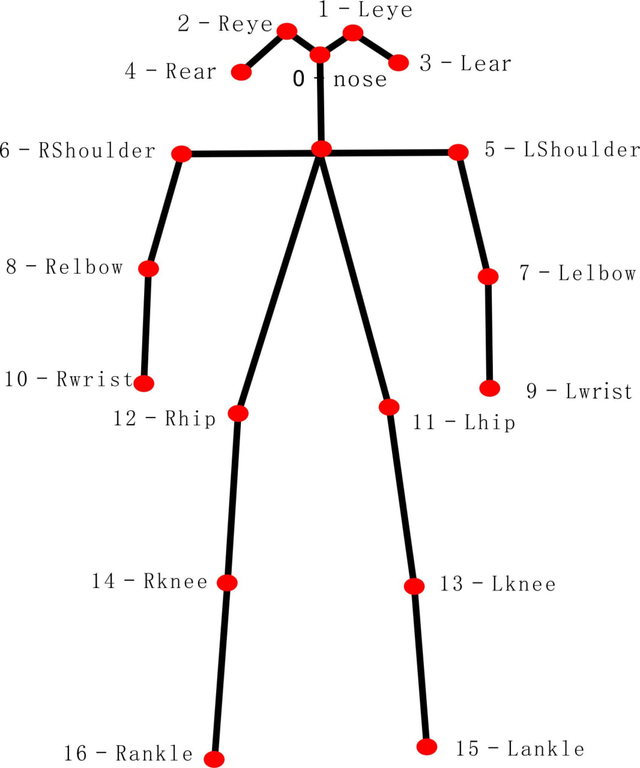

In [ ]:
def get_coco_right_elbow_triplet (df):
    # Select: shoulder, elbow, wrist coordinates
    shoulder = df[ ['X6','Y6'  ] ]
    elbow    = df[ ['X8','Y8'  ] ]
    wrist    = df[ ['X10','Y10'] ]
    return shoulder,elbow,wrist

def get_coco_left_elbow_triplet (df):
    # Select: shoulder, elbow, wrist coordinates
    shoulder = df[ ['X5','Y5'] ]
    elbow    = df[ ['X7','Y7'] ]
    wrist    = df[ ['X9','Y9'] ]
    return shoulder,elbow,wrist

In [ ]:
def calculate_angle(p0,c,p1, output=False):
    # Input: point_0, point_1 and central point are pandas Series
    if (p0[0].shape == p1[0].shape) and (p0[0].shape == c[0].shape):

        p0c  = (c[0].sub(p0[0] ).pow(2) + c[1].sub(p0[1] ).pow(2) ).pow(1/2)    # p0->c   ((p0[x]-c[x] )^2  + (p0[y]-c[y] )^2)^(1/2)
        p1c  = (c[0].sub(p1[0] ).pow(2) + c[1].sub(p1[1] ).pow(2) ).pow(1/2)    # p1->c   ((p1[x]-c[x] )^2  + (p1[y]-c[y] )^2)^(1/2)
        p0p1 = (p1[0].sub(p0[0]).pow(2) + p1[1].sub(p0[1]).pow(2) ).pow(1/2)    # p0->p1  ((p0[x]-p1[x])^2  + (p0[y]-p1[y])^2)^(1/2)

        cos = (p1c.pow(2) + p0c.pow(2) - p0p1.pow(2)).div(p1c.mul(p0c).mul(2))

        angle_radian =  np.arccos( cos )
        angle_degrees = np.degrees( angle_radian )

        if output:
            print("Radians = ", angle_radian)
            print("Degrees = ", angle_degrees)

        # Output: radians, degress.
        return angle_radian, angle_degrees
    else:
        raise ValueError ("Input series' shapes mismatch")

In [ ]:
import os
import re
from hyperimpute.plugins.imputers import Imputers

# Select a folder with video files and read it
PATH_patients = PATH_data + 'patients/'

def process_stroke_video_data(patient):

    # set download data folder PATH
    PATH_data_patient = PATH_patients + patient + '/video/'
    # set divided frames folder PATH
    PATH_frames_patient = PATH_frames + patient + '/'
    PATH_frames_tmp = PATH_frames + 'test/'

    PATH_out_patient    = PATH_output + patient + '/'
    create_folder (PATH_out_patient, overwrite=True)

    # find all available days of video recording and save as "days" array

    days = []
    for cur_path in os.listdir(PATH_data_patient):
        # check if current path is a file
        if os.path.isdir(os.path.join(PATH_data_patient, cur_path)):
            days.append(cur_path)
    print(days)

    #days     = ['20210401']
    #hours    = ['13']#,'14']

    # intiate arrays for expected joints' coordinates and time of this estimation
    coordinates = []
    time = []

    '''
    vidcap = cv2.VideoCapture(PATH_data_video)
    old_fps = int(vidcap.get(cv2.CAP_PROP_FPS) )
    print("Frames per second = {0}.".format( int(old_fps) ) )
    frames_number = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Number of frames = {0}.".format( int(frames_number) ) )

    # Set desired FPS = 1
    new_fps = 1
    step = int(old_fps / new_fps)
    print('step = {0}.', format(step))
    '''
    # old FPS = 15, new FPS = 1. We need to select each 15th frame to read
    frames = 900
    step = 15

    #frames_per_minute = frames/step # I decided it should be 900/15 = 60


    for day in days:
        PATH_data_day   = PATH_data_patient + day + '/'
        PATH_frames_day = PATH_frames_patient + day + '/'


        hours = []
        for cur_path in os.listdir(PATH_data_day):
            # check if current path is a file
            if os.path.isdir(os.path.join(PATH_data_day, cur_path)):
                hours.append(cur_path)
        print(hours)


        for hour in hours:

            create_folder (PATH_frames_tmp, overwrite=True)
            PATH_data_hour   = PATH_data_day + hour + '/'

            file_names = []
            # Iterate directory
            for cur_path in os.listdir(PATH_data_hour):
                # check if current path is a file
                if os.path.isfile(os.path.join(PATH_data_hour, cur_path)):
                    file_names.append(cur_path)

            file_names.sort()
            file_numbers = []
            for i in (file_names):
                file_numbers.append( int(re.findall(r'\d+',i)[0]) )

            files = list(zip(file_numbers, file_names))

            print('hour is: ',hour)
            print ('first minute is: ',min(file_numbers))
            #first_minute = min(file_numbers)
            #minute = first_minute
            #saved_count = first_minute + (saving_minute-1)*frames_per_minute
            saved_count = 0

            for file_number,file_name in files:

                #print('number = {}, name = {}'.format(file_number,file_name))
                PATH_file_video = PATH_data_hour + file_name

                vidcap = cv2.VideoCapture(PATH_file_video)
                success,frame = vidcap.read()

                if not success:
                    print('Video {} was NOT found.'.format(PATH_file_video)) #?!

                # Cut video into frames
                frame_count = 0

                while success:
                    name = "frame_%d.png" % saved_count
                    PATH_frame_save = os.path.join(PATH_frames_tmp , name)
                    #print(PATH_frame_save)
                    cv2.imwrite( PATH_frame_save, frame )
                    #print('Saved a new frame',saved_count,' (№', int(frame_count), 'original frame) ')

                    frame_count += step # i.e. at 15 fps, this advances one second
                    vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
                    success,frame = vidcap.read()

                    #
                    keypoints = calculate_show_keypoints_coordinates (det_model, pose_model, PATH_frame_save, show=False)

                    # Initialize a temporary array with coordinates (X,Y,Z) of the first keypoint
                    tmp = keypoints[points_list[0]]
                    for point_number in points_list[1:]:
                        # Add as a new row (vertically) x1, y1, z1, x2, y2, z2, ...
                        tmp = np.hstack((tmp,keypoints[point_number]))
                    coordinates.append(tmp)

                    minute = int(file_number)
                    tmp_time = [patient, day, hour, minute, saved_count]
                    time.append(tmp_time)
                    saved_count += 1 # we have saved and processed 1 frame out of video. Each 60 sec video has 900 frames, but we use only 60 of them.

                vidcap.release()




    coordinates_np = np.array(coordinates)
    time_np        = np.array(time)

    # Create a pandas DataFrame of keypoints data, where each row is a consequent frame of the processed video
    df = pd.DataFrame(coordinates_np, columns=[all_coordinates_np])
    #df.head(5)
    df_time = pd.DataFrame(time_np, columns=['patient','day','hour','minute','frame'])

    # replace missing defined by '-1' values ( from calculate_show_keypoints_coordinates() ) as NaN objects
    df = df.copy().replace(-1.000000, np.nan)
    # remove multiple people defined by '-2' values ( from calculate_show_keypoints_coordinates() ) as NaN objects
    df = df.copy().replace(-2.000000, np.nan)
    #df.drop(df[df['X5'] == -2].index, inplace = True)

    #available_imputers = Imputers() ---> 'softimpute', 'mice', 'miwae', 'mean', 'sinkhorn', 'missforest', 'sklearn_ice', 'most_frequent', 'nop', 'sklearn_missforest', 'gain', 'median', 'ice', 'EM', 'miracle', 'hyperimpute'
    method = "mean"
    plugin = Imputers().get(method)

    #df.head(5)

    df = plugin.fit_transform(df)
    df.columns =  all_coordinates_np


    # Form a triplet [p0(x,y), c(x,y), p1(x,y)]
    triplet = get_coco_right_elbow_triplet(df)
    p0 = [ triplet[0].iloc[:,0],  triplet[0].iloc[:,1] ]
    c  = [ triplet[1].iloc[:,0],  triplet[1].iloc[:,1] ]
    p1 = [ triplet[2].iloc[:,0],  triplet[2].iloc[:,1] ]

    degrees = calculate_angle(p0,c,p1, output=True) [1]

    # Using DataFrame.insert() to add a column
    df.insert(loc=len(df.columns), column="r_degr", value=degrees, allow_duplicates=False)

    # Form a triplet [p0(x,y), c(x,y), p1(x,y)]
    triplet = get_coco_left_elbow_triplet(df)
    p0 = [ triplet[0].iloc[:,0],  triplet[0].iloc[:,1] ]
    c  = [ triplet[1].iloc[:,0],  triplet[1].iloc[:,1] ]
    p1 = [ triplet[2].iloc[:,0],  triplet[2].iloc[:,1] ]

    degrees = calculate_angle(p0,c,p1) [1]
    # Using DataFrame.insert() to add a column
    df.insert(loc=len(df.columns), column="l_degr", value=degrees, allow_duplicates=False)

    df = pd.concat([df, df_time], axis=1)

    PATH_final_out = PATH_out_patient + patient + '.csv'
    print ('saving results: ', PATH_final_out)

    '''
    file_path = 'raw_coord_angle.csv'
    filepath = Path(PATH_out_minute, file_path)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    '''

    # Save coordinates and angle as a CSV tabular dataframe
    df.to_csv(PATH_final_out)

In [ ]:
patient = 'BD_07'
process_stroke_video_data(patient)

In [ ]:
def process_stroke_video_data_v2(patient, if_rotate=False):

    # set download data folder PATH
    PATH_data_patient = PATH_patients + patient + '/video/'
    # set divided frames folder PATH
    PATH_frames_patient = PATH_frames + patient + '/'
    PATH_frames_tmp = PATH_frames + 'test/'

    PATH_out_patient    = PATH_output + patient + '/'
    create_folder (PATH_out_patient, overwrite=True)

    # find all available days of video recording and save as "days" array

    days = []

    for cur_path in os.listdir(PATH_data_patient):
        # check if current path is a file
        if os.path.isdir(os.path.join(PATH_data_patient, cur_path)):
            days.append(cur_path)
    print(days)

    # COMMENT THIS
    #days     = ['20210626']
    #hours    = ['13']

    # intiate arrays for expected joints' coordinates and time of this estimation
    coordinates = []
    time = []

    '''
    vidcap = cv2.VideoCapture(PATH_data_video)
    old_fps = int(vidcap.get(cv2.CAP_PROP_FPS) )
    print("Frames per second = {0}.".format( int(old_fps) ) )
    frames_number = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Number of frames = {0}.".format( int(frames_number) ) )

    # Set desired FPS = 1
    new_fps = 1
    step = int(old_fps / new_fps)
    print('step = {0}.', format(step))
    '''
    # old FPS = 15, new FPS = 1. We need to select each 15th frame to read
    frames = 900
    step = 15

    #frames_per_minute = frames/step # I decided it should be 900/15 = 60


    for day in days:
        PATH_data_day   = PATH_data_patient + day + '/'
        PATH_frames_day = PATH_frames_patient + day + '/'

        hours = []
        for cur_path in os.listdir(PATH_data_day):
            # check if current path is a file
            if os.path.isdir(os.path.join(PATH_data_day, cur_path)):
                hours.append(cur_path)
        print(hours)

        for hour in hours:

            create_folder (PATH_frames_tmp, overwrite=True)
            PATH_data_hour   = PATH_data_day + hour + '/'

            file_names = []
            # Iterate directory
            for cur_path in os.listdir(PATH_data_hour):
                # check if current path is a file
                if os.path.isfile(os.path.join(PATH_data_hour, cur_path)):
                    file_names.append(cur_path)

            file_names.sort()
            file_numbers = []
            for i in (file_names):
                file_numbers.append( int(re.findall(r'\d+',i)[0]) )

            files = list(zip(file_numbers, file_names))

            print('hour is: ',hour)
            print ('first minute is: ',min(file_numbers))
            #first_minute = min(file_numbers)
            #minute = first_minute
            #saved_count = first_minute + (saving_minute-1)*frames_per_minute
            saved_count = 0

            for file_number, file_name in files[0:3]:
            #for file_number,file_name in files:

                #print('number = {}, name = {}'.format(file_number,file_name))
                PATH_file_video = PATH_data_hour + file_name

                vidcap = cv2.VideoCapture(PATH_file_video)
                success,frame = vidcap.read()


                if not success:
                    print('Video {} was NOT found.'.format(PATH_file_video)) #?!

                # Cut video into frames
                frame_count = 0

                while success:
                    if if_rotate:
                        '''
                        # get image height, width
                        (h, w) = frame.shape[:2]
                        # calculate the center of the image
                        center = (w // 2, h // 2)
                        M_270 = cv2.getRotationMatrix2D(center, 90, 1.0)
                        frame_rotated = cv2.warpAffine(frame, M_270, (h, w),flags=cv2.INTER_LINEAR)
                        '''
                        rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE #cv2.ROTATE_90_CLOCKWISE or ROTATE_180 or ROTATE_90_COUNTERCLOCKWISE
                        frame = cv2.rotate(frame, rotateCode)
                    name = "frame_%d.png" % saved_count
                    PATH_frame_save = os.path.join(PATH_frames_tmp , name)
                    #print(PATH_frame_save)
                    cv2.imwrite( PATH_frame_save, frame )
                    #print('Saved a new frame',saved_count,' (№', int(frame_count), 'original frame) ')

                    frame_count += step # i.e. at 15 fps, this advances one second
                    vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
                    success,frame = vidcap.read()

                    keypoints = calculate_show_keypoints_coordinates (det_model, pose_model, PATH_frame_save, show=False)

                    # Initialize a temporary array with coordinates (X,Y,Z) of the first keypoint
                    tmp = keypoints[points_list[0]]
                    for point_number in points_list[1:]:
                        # Add as a new keypoint (horizontally) x1, y1, z1, x2, y2, z2, ...
                        tmp = np.hstack((tmp,keypoints[point_number]))
                    coordinates.append(tmp)

                    minute = int(file_number)
                    tmp_time = [patient, day, hour, minute, saved_count] # we do not use reminder of division 60 because some records are 59 or 61 seconds long
                    time.append(tmp_time)
                    saved_count += 1 # we have saved and processed 1 frame out of video. Each 60 sec video has 900 frames, but we use only 60 of them.

                vidcap.release()




    coordinates_np = np.array(coordinates)
    time_np        = np.array(time)

    # Create a pandas DataFrame of keypoints data, where each row is a consequent frame of the processed video
    df = pd.DataFrame( coordinates_np, columns=[all_coordinates_np] )
    #df.head(5)
    df_time = pd.DataFrame(time_np, columns=['patient','day','hour','minute','frame'])


    df_time['if_nobody']          = np.where(df['X1'] == '-1.000000', True, False)
    df_time['if_multiple_people'] = np.where(df['X1'] == '-2.000000', True, False)

    # replace missing defined by '-1' values ( from calculate_show_keypoints_coordinates() ) as NaN objects
    df = df.replace(-1.000000, np.nan)
    # remove multiple people defined by '-2' values ( from calculate_show_keypoints_coordinates() ) as NaN objects
    df = df.replace(-2.000000, np.nan)
    #df.drop(df[df['X5'] == -2].index, inplace = True)
    df['if_imputed'] = np.where(df['X1'] == np.nan, True, False)

    #available_imputers = Imputers() ---> 'softimpute', 'mice', 'miwae', 'mean', 'sinkhorn', 'missforest', 'sklearn_ice', 'most_frequent', 'nop', 'sklearn_missforest', 'gain', 'median', 'ice', 'EM', 'miracle', 'hyperimpute'
    method = "mice"
    plugin = Imputers().get(method)

    #df.head(5)

    df = plugin.fit_transform( df )
    df.head()

    df.columns =  all_coordinates_np

    #['if_nobody', 'if_multiple_people', 'if_imputed'])
    #df2.join(df['if_imputed'])


    # Form a triplet [p0(x,y), c(x,y), p1(x,y)]
    triplet = get_coco_right_elbow_triplet(df)
    p0 = [ triplet[0].iloc[:,0],  triplet[0].iloc[:,1] ]
    c  = [ triplet[1].iloc[:,0],  triplet[1].iloc[:,1] ]
    p1 = [ triplet[2].iloc[:,0],  triplet[2].iloc[:,1] ]

    degrees = calculate_angle(p0,c,p1, output=True) [1]

    # Using DataFrame.insert() to add a column
    df.insert(loc=len(df.columns), column="r_degr", value=degrees, allow_duplicates=False)

    # Form a triplet [p0(x,y), c(x,y), p1(x,y)]
    triplet = get_coco_left_elbow_triplet(df)
    p0 = [ triplet[0].iloc[:,0],  triplet[0].iloc[:,1] ]
    c  = [ triplet[1].iloc[:,0],  triplet[1].iloc[:,1] ]
    p1 = [ triplet[2].iloc[:,0],  triplet[2].iloc[:,1] ]

    degrees = calculate_angle(p0,c,p1) [1]
    # Using DataFrame.insert() to add a column
    df.insert(loc=len(df.columns), column="l_degr", value=degrees, allow_duplicates=False)

    df = pd.concat([df, df_time], axis=1)

    PATH_final_out = PATH_out_patient + patient + '_v3.csv'
    print ('saving results: ', PATH_final_out)

    '''
    file_path = 'raw_coord_angle.csv'
    filepath = Path(PATH_out_minute, file_path)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    '''

    # Save coordinates and angle as a CSV tabular dataframe
    df.to_csv(PATH_final_out)

In [ ]:
patient = 'AK_34'
process_stroke_video_data_v2 (patient, if_rotate=True)

The directory already exists. Folder overwritinig ...
['20210626', '20210627', '20210628']
['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
The directory already exists. Folder overwritinig ...
hour is:  11
first minute is:  49
